In [1]:
import pygplates
import pygmt
import numpy as np
import matplotlib.pyplot as plt
import os.path

from gprm import ReconstructionModel, MotionPathFeature
from gprm.datasets import Reconstructions

print(pygplates.__version__)

%load_ext autoreload
%autoreload 2

2.4.0.33


In [2]:
#######################################################
# Define Input files
#######################################################

model_dir = 'Global_1000-0_Model_2017'

# Where to find the model.
input_dir = '../data/{0}'.format(model_dir)
# Output figures in 'model_dir' subdirectory of this notebook (in 'figures/' directory).
output_dir = './{0}'.format(model_dir)

if model_dir.startswith('Global_1000-0_Model_2017'):
    M2020 = ReconstructionModel('Rodinia')
    M2020.add_rotation_model('{0}/1000_0_rotfile_Merdith_et_al.rot'.format(input_dir))
    M2020.add_dynamic_polygons('{0}/1000-410-Convergence_Merdith_et_al.gpml'.format(input_dir))
    M2020.add_dynamic_polygons('{0}/1000-410-Divergence_Merdith_et_al.gpml'.format(input_dir))
    M2020.add_dynamic_polygons('{0}/1000-410-Topologies_Merdith_et_al.gpml'.format(input_dir))
    M2020.add_dynamic_polygons('{0}/1000-410-Transforms_Merdith_et_al.gpml'.format(input_dir))
    M2020.add_dynamic_polygons('{0}/250-0_plate_boundaries_Merdith_et_al.gpml'.format(input_dir))
    M2020.add_dynamic_polygons('{0}/410-250_plate_boundaries_Merdith_et_al.gpml'.format(input_dir))
    M2020.add_dynamic_polygons('{0}/TopologyBuildingBlocks_Merdith_et_al.gpml'.format(input_dir))
    M2020.add_continent_polygons('{0}/shapes_continents_Merdith_et_al.gpml'.format(input_dir))


    M2020_opt = M2020.copy()
    M2020_opt.add_rotation_model(
        '{0}/optimisation/optimised_rotation_model_git_20210802_ce53d67_run45.rot'.format(input_dir), replace=True)

else:
    raise NotImplementedError

TC2017 = Reconstructions.fetch_TorsvikCocks2017()

Introversion = Reconstructions.fetch_CaoToyRodinia(model_case='SSL')

Orthoversion = Reconstructions.fetch_CaoToyRodinia(model_case='OV')

NNR = Reconstructions.fetch_CaoToyRodinia(model_case='NNR')


In [3]:
reconstruction_time = 800.

def rodinia_panel(reconstruction_model, name,
                  reconstruction_time, transparancy=0.):
        
    reconstructed_continents = reconstruction_model.polygon_snapshot('continents', 
                                                                     reconstruction_time)
    reconstructed_coastlines = reconstruction_model.polygon_snapshot('coastlines', 
                                                                     reconstruction_time)
    plate_boundaries = reconstruction_model.plate_snapshot(reconstruction_time)

    fig.basemap(region='d', projection='W6c', frame='f')
    fig.coast(land='gray95')
    if reconstructed_continents.reconstructed_polygons:
        reconstructed_continents.plot(fig, color='wheat')
    if reconstructed_coastlines.reconstructed_polygons:
        reconstructed_coastlines.plot(fig, color='wheat')
    if plate_boundaries.resolved_topologies:
        plate_boundaries.plot_subduction_zones(fig)
    fig.basemap(frame='g45')
    #fig.basemap(region='d', projection='W6i', frame='ag')
    fig.text(x=0.04,y=0.45,text='{:0.0f} Ma'.format(reconstruction_time),
             region='0/1/0/1', projection='x6c', font='9,,', N=True)
    fig.text(x=0.04,y=0.5,text='{:s}'.format(name),
             region='0/1/0/1', projection='x6c', font='9,,', N=True)
    
    return fig

model_list = [
    (TC2017, 'TC2017'),
    (NNR,'NNR'),
    (Orthoversion,'Orthoversion'),
    (Introversion,'Introversion'),
    (M2020, 'pre-opt'),
    (M2020_opt,'Opt_run45')]

fig = pygmt.Figure()
for reconstruction_time in [200,300,400,500]:
    for model in model_list:
        if (reconstruction_time>550.) & (model[1]=='TC2017'):
            fig.shift_origin(yshift='3.2c')
            continue
        fig = rodinia_panel(model[0], model[1], reconstruction_time, transparancy=30.)
        fig.shift_origin(yshift='3.2c')
    
    fig.shift_origin(xshift='6.5c',yshift='-19.2c')
    
fig.show(width=1000)

fig.savefig(os.path.join(output_dir, 'Optimisation_MultiPanelModelComparison_200_500Ma.png'))


In [4]:
model_list = [
    (NNR,'NNR'),
    (Orthoversion,'Orthoversion'),
    (Introversion,'Introversion'),
    (M2020, 'pre-opt'),
    (M2020_opt,'Opt_run45')]

fig = pygmt.Figure()
for reconstruction_time in [600,700,800,900]:
    for model in model_list:
        if (reconstruction_time>550.) & (model[1]=='TC2017'):
            fig.shift_origin(yshift='3.2c')
            continue
        fig = rodinia_panel(model[0], model[1], reconstruction_time, transparancy=30.)
        fig.shift_origin(yshift='3.2c')
    
    fig.shift_origin(xshift='6.5c',yshift='-16c')
    
fig.show(width=1000)

fig.savefig(os.path.join(output_dir, 'Optimisation_MultiPanelModelComparison_600_900Ma.png'))


In [5]:
def PlotTrails(fig,Trails,color,path_times, label=None):
    for Trail in Trails:
        fig.plot(Trail[:,1], Trail[:,0], pen='1.2p,{:s}'.format(color),label=label)
        fig.plot(x=Trail[::5,1],y=Trail[::5,0],style='c0.2c',pen=color,
                 cmap='plasma',color=path_times[::5]/1000.)
        fig.plot(Trail[-1,1],Trail[-1,0],style='a0.2i', color='black')

def PlotTrailFigure(coord,plate_id,title_string,projection='W6i',region='d'):
    
    fig = pygmt.Figure()
    fig.basemap(region=region, projection=projection, frame='afg')
    fig.coast(land='lightgray')

    #LaurentiaPath = MotionPathFeature(seed_points=(45,-90),path_times=np.arange(0.,1001.,10.),reconstruction_plate_id=101)

    #Trails = MotionPathFeature(seed_points=coord,
    #                           path_times=np.arange(0.,1001.,10.),
    #                           reconstruction_plate_id=plate_id).reconstruct_motion_path(M2020)
    #PlotTrails(fig,Trails,'black',np.arange(1000.,-1.,-10.), label='No_Optimisation')

    Trails = MotionPathFeature(seed_points=coord,
                               path_times=np.arange(0.,1001.,10.),
                               reconstruction_plate_id=plate_id).reconstruct_motion_path(M2020_opt)
    PlotTrails(fig,Trails,'red',np.arange(1000.,-1.,-10.), label='opt45')

    Trails = MotionPathFeature(seed_points=coord,
                               path_times=np.arange(0.,541.,10.),
                               reconstruction_plate_id=plate_id).reconstruct_motion_path(TC2017)
    PlotTrails(fig,Trails,'cyan',np.arange(540.,-1.,-10.), label='TC2017mantle')
    
    Trails = MotionPathFeature(seed_points=coord,
                               path_times=np.arange(0.,541.,10.),
                               reconstruction_plate_id=plate_id).reconstruct_motion_path(Introversion)
    PlotTrails(fig,Trails,'blue',np.arange(540.,-1.,-10.), label='Introversion')
    
    Trails = MotionPathFeature(seed_points=coord,
                               path_times=np.arange(0.,541.,10.),
                               reconstruction_plate_id=plate_id).reconstruct_motion_path(Orthoversion)
    PlotTrails(fig,Trails,'gold',np.arange(540.,-1.,-10.), label='Orthoversion')
    
    Trails = MotionPathFeature(seed_points=coord,
                               path_times=np.arange(0.,541.,10.),
                               reconstruction_plate_id=plate_id).reconstruct_motion_path(NNR)
    PlotTrails(fig,Trails,'gray',np.arange(540.,-1.,-10.), label='NNR')
    
    fig.basemap(region=region, projection=projection, frame='afg')
    
    fig.colorbar(
    cmap='plasma',
    position='JMR+o1.5c/-2c+w4c/1c',  # justified inside map frame (j) at Top Center (TC)
    box=False,
    frame=['xaf', 'y+lMa'],
    scale=1000
    )
     
    fig.legend(position="JMR+o0.5c/2.5c", box=True)
    
    return fig

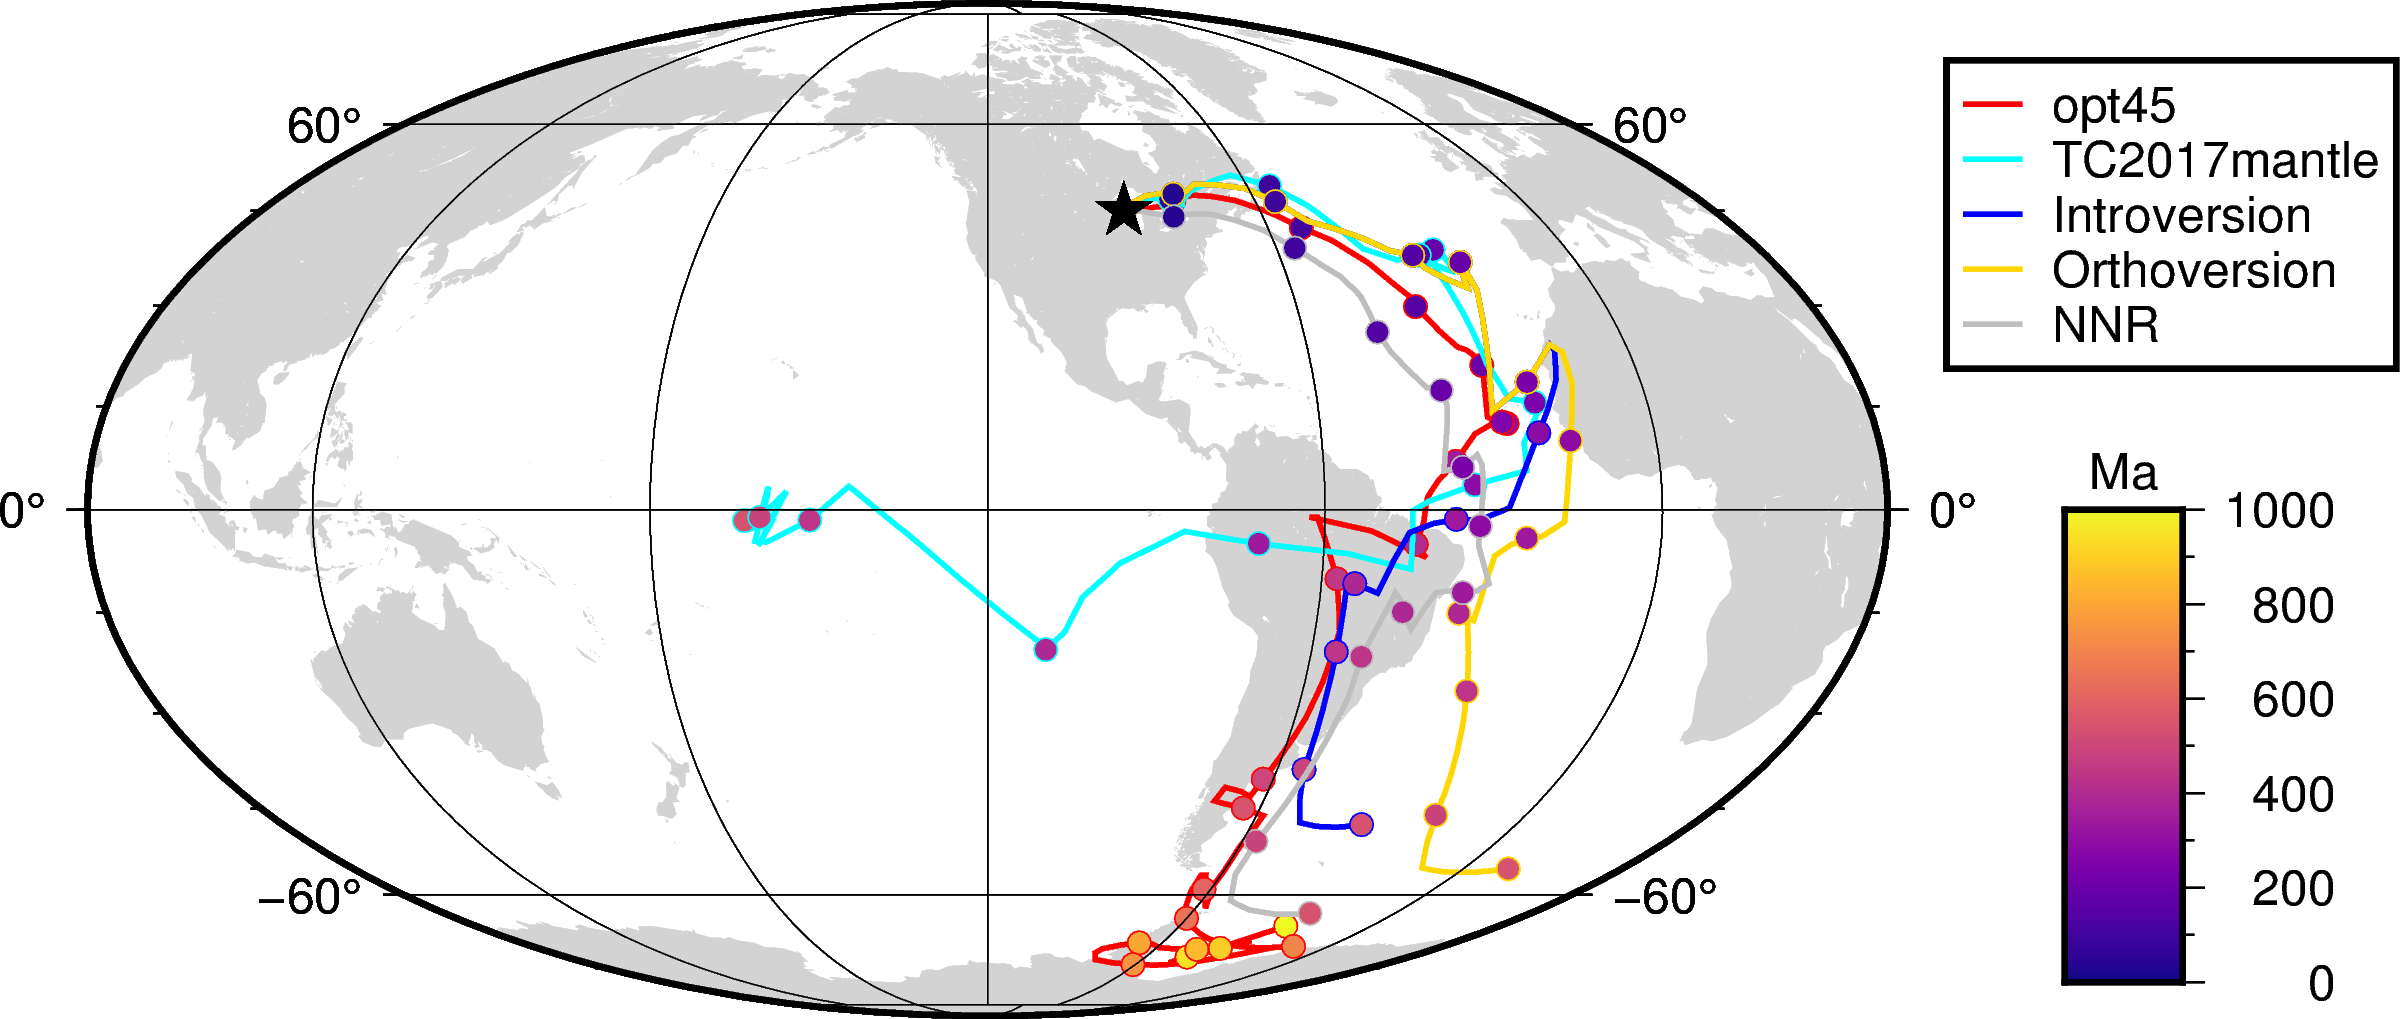

In [6]:
# Note that here, the first argument to the function 'PlotTrailFigure'
# defines the seed point for the motion path as (Latitude,Longitude)

region=[-280,40,-90,90]
fig = PlotTrailFigure((45,-90), 101, 'Laurentia', region=region)
fig.show(width=1000)

#fig.savefig(os.path.join(output_dir, 'OptimisationComparison_MotionPath_Laurentia.png'))

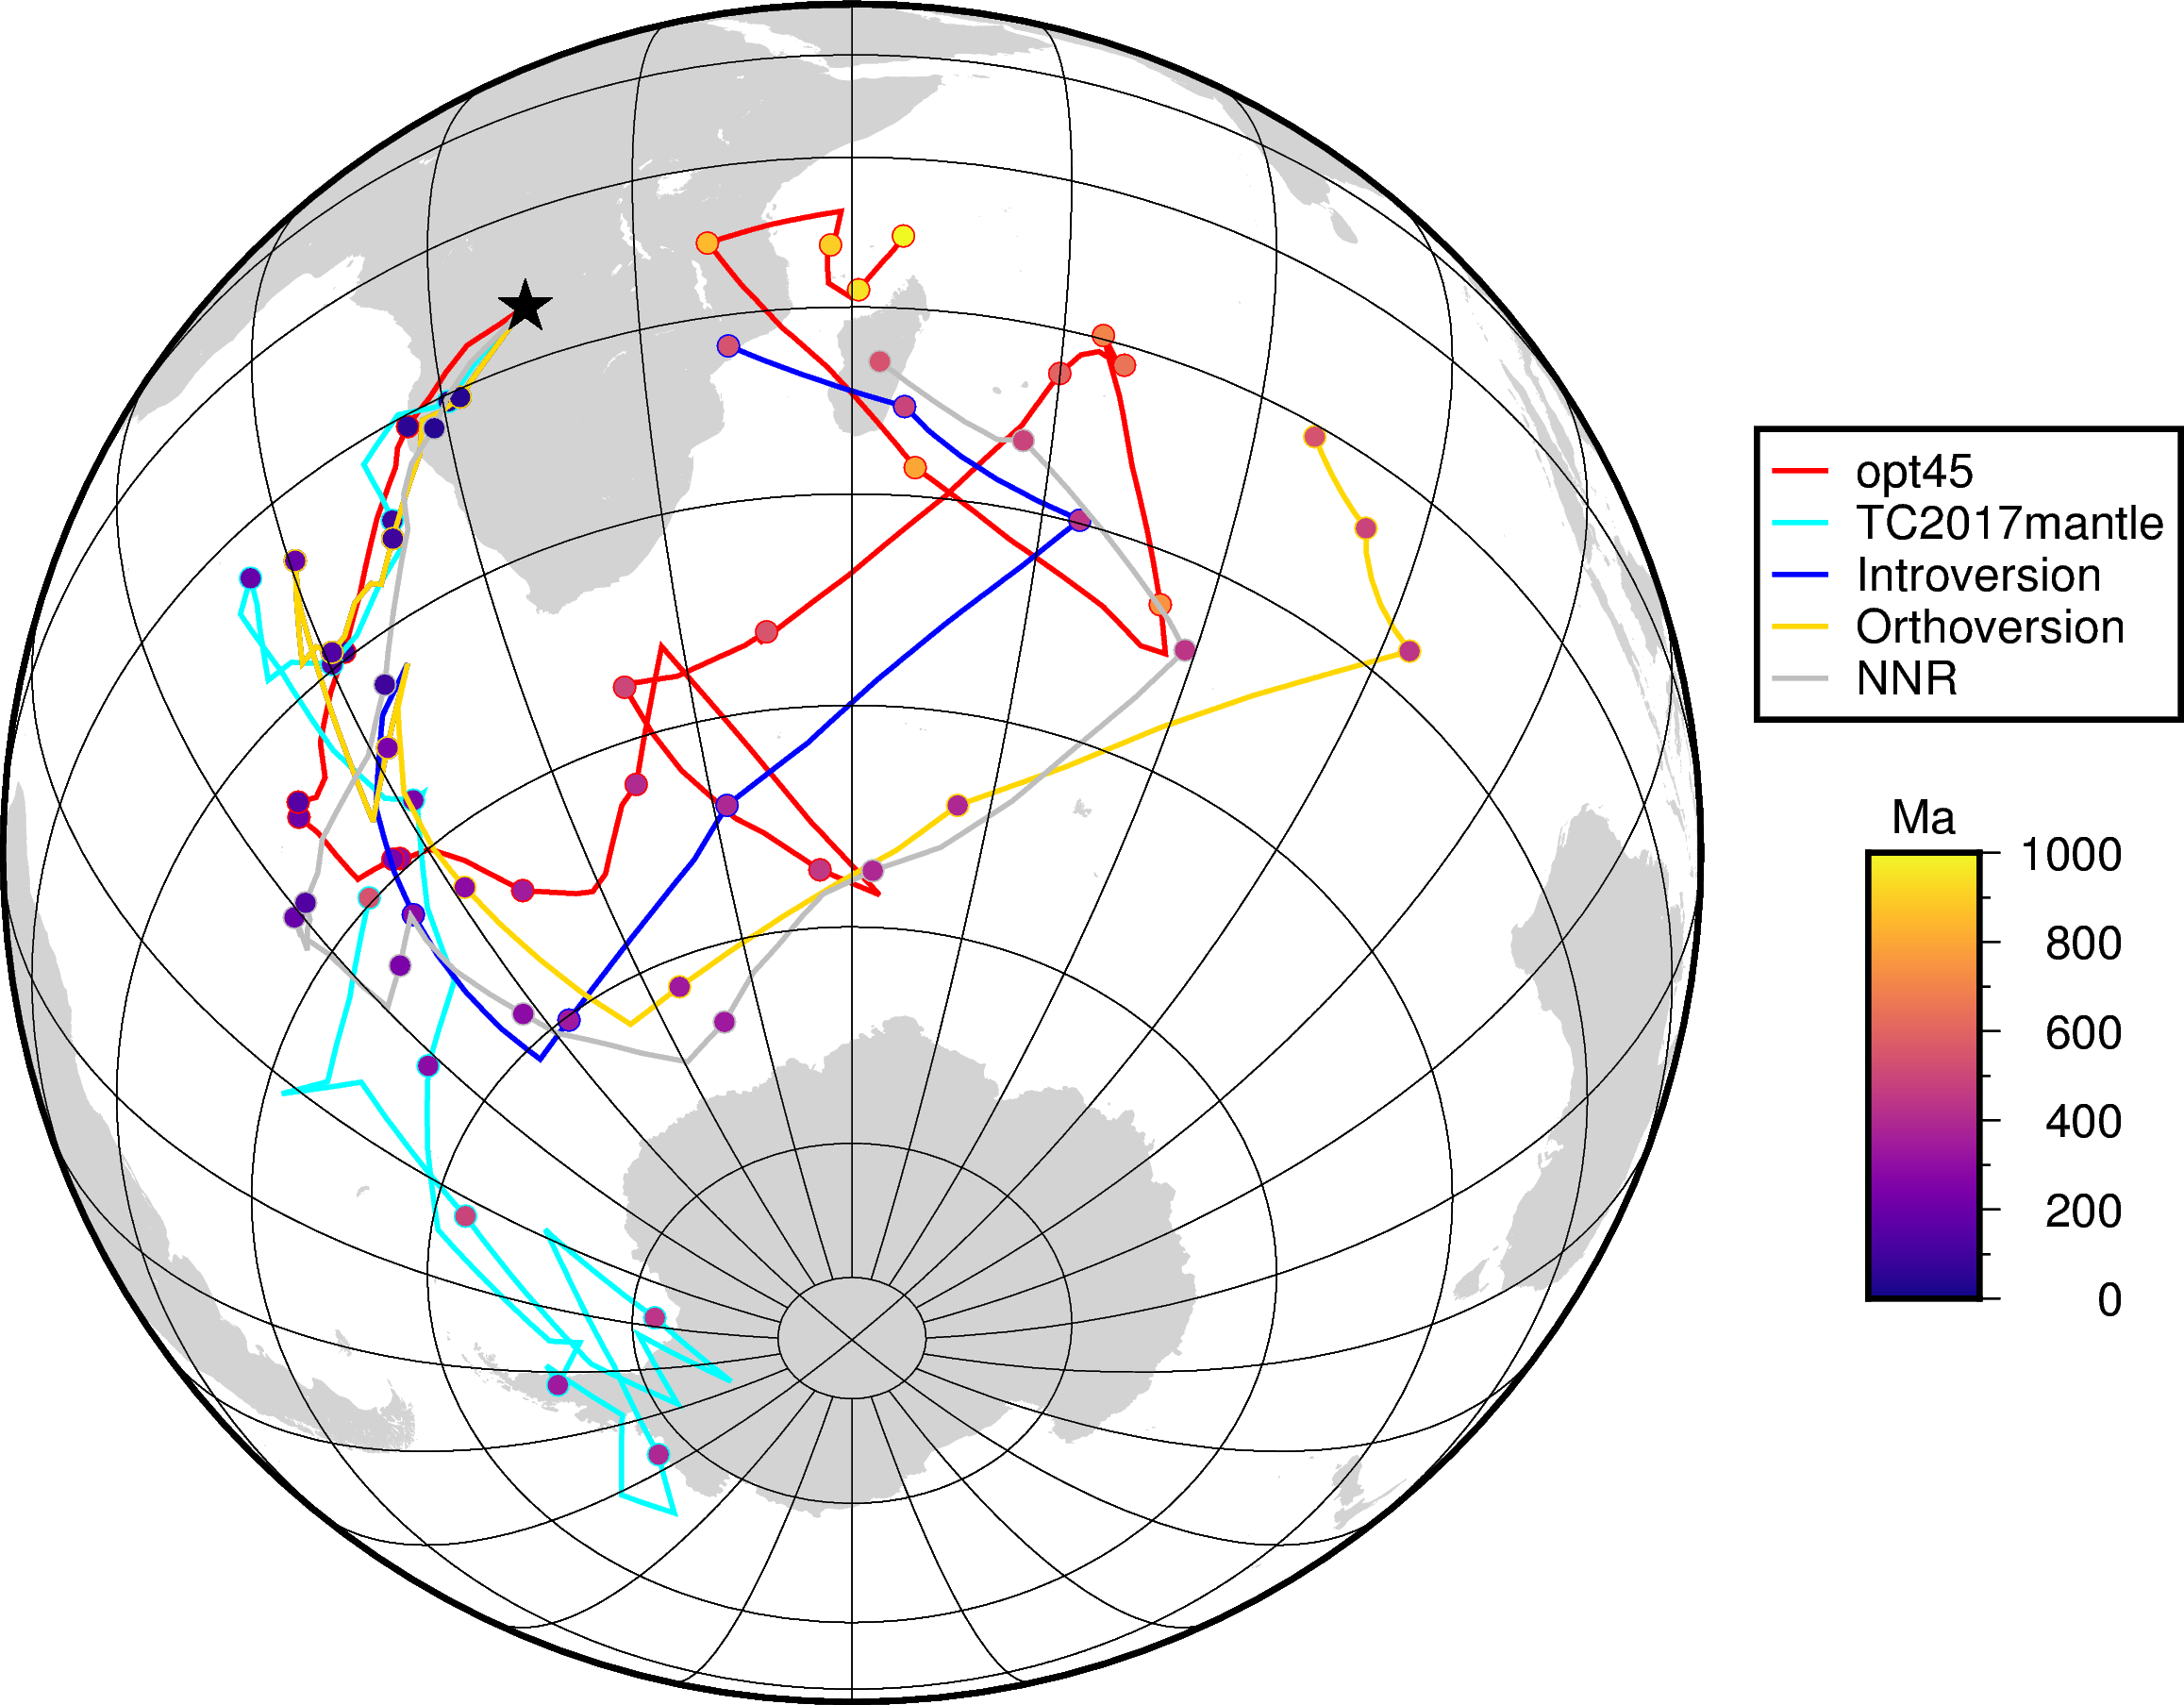

In [7]:
fig = PlotTrailFigure((-10,22),701, 'Congo', projection='G45/-55/6i')
fig.show(width=800)

#fig.savefig(os.path.join(output_dir, 'OptimisationComparison_MotionPath_Congo.png'))

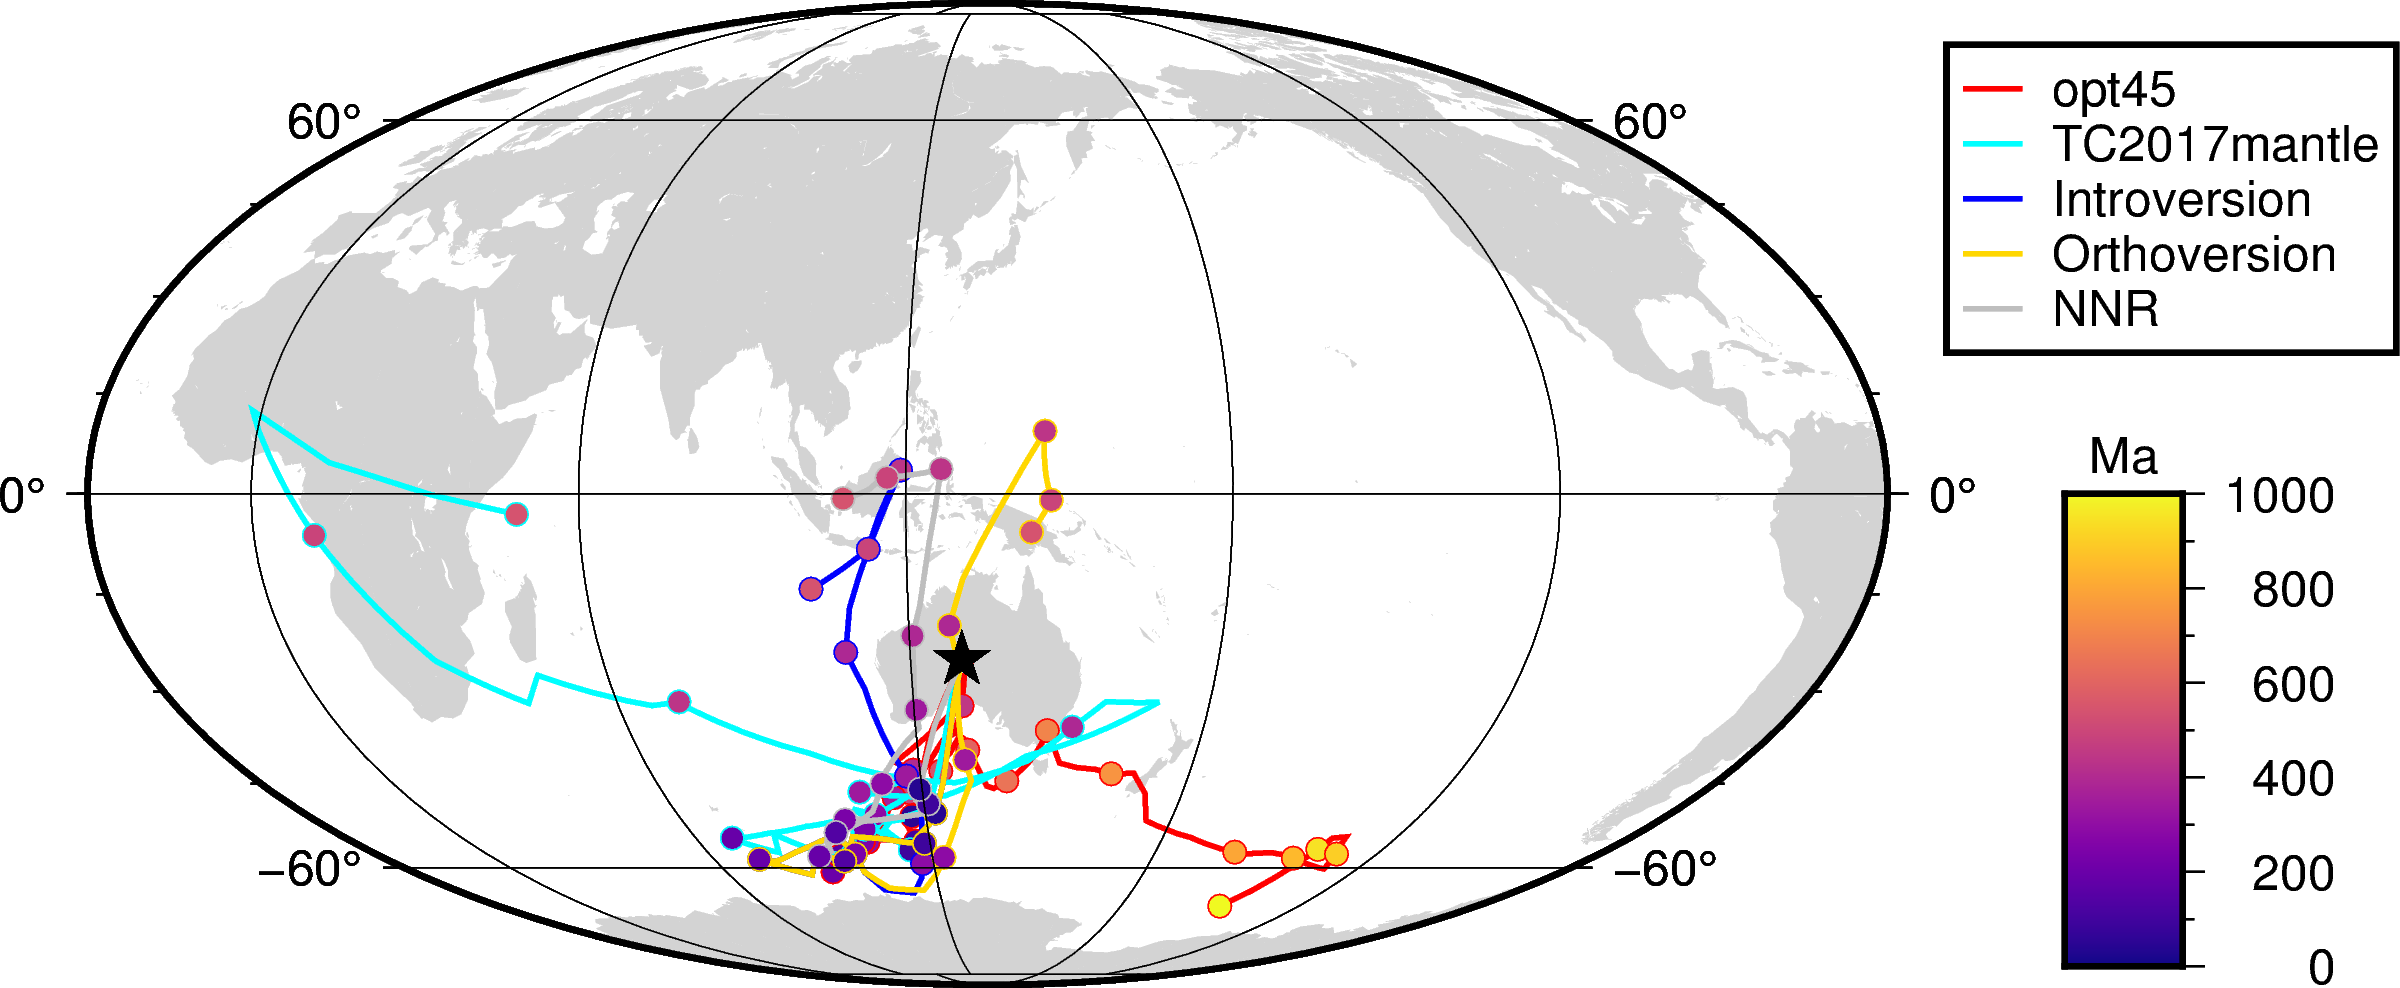

In [8]:
fig = PlotTrailFigure((-25,130),801, 'Australia', region=[-30,300,-90,90]) 
fig.show(width=800)

#fig.savefig(os.path.join(output_dir, 'OptimisationComparison_MotionPath_Australia.png'))


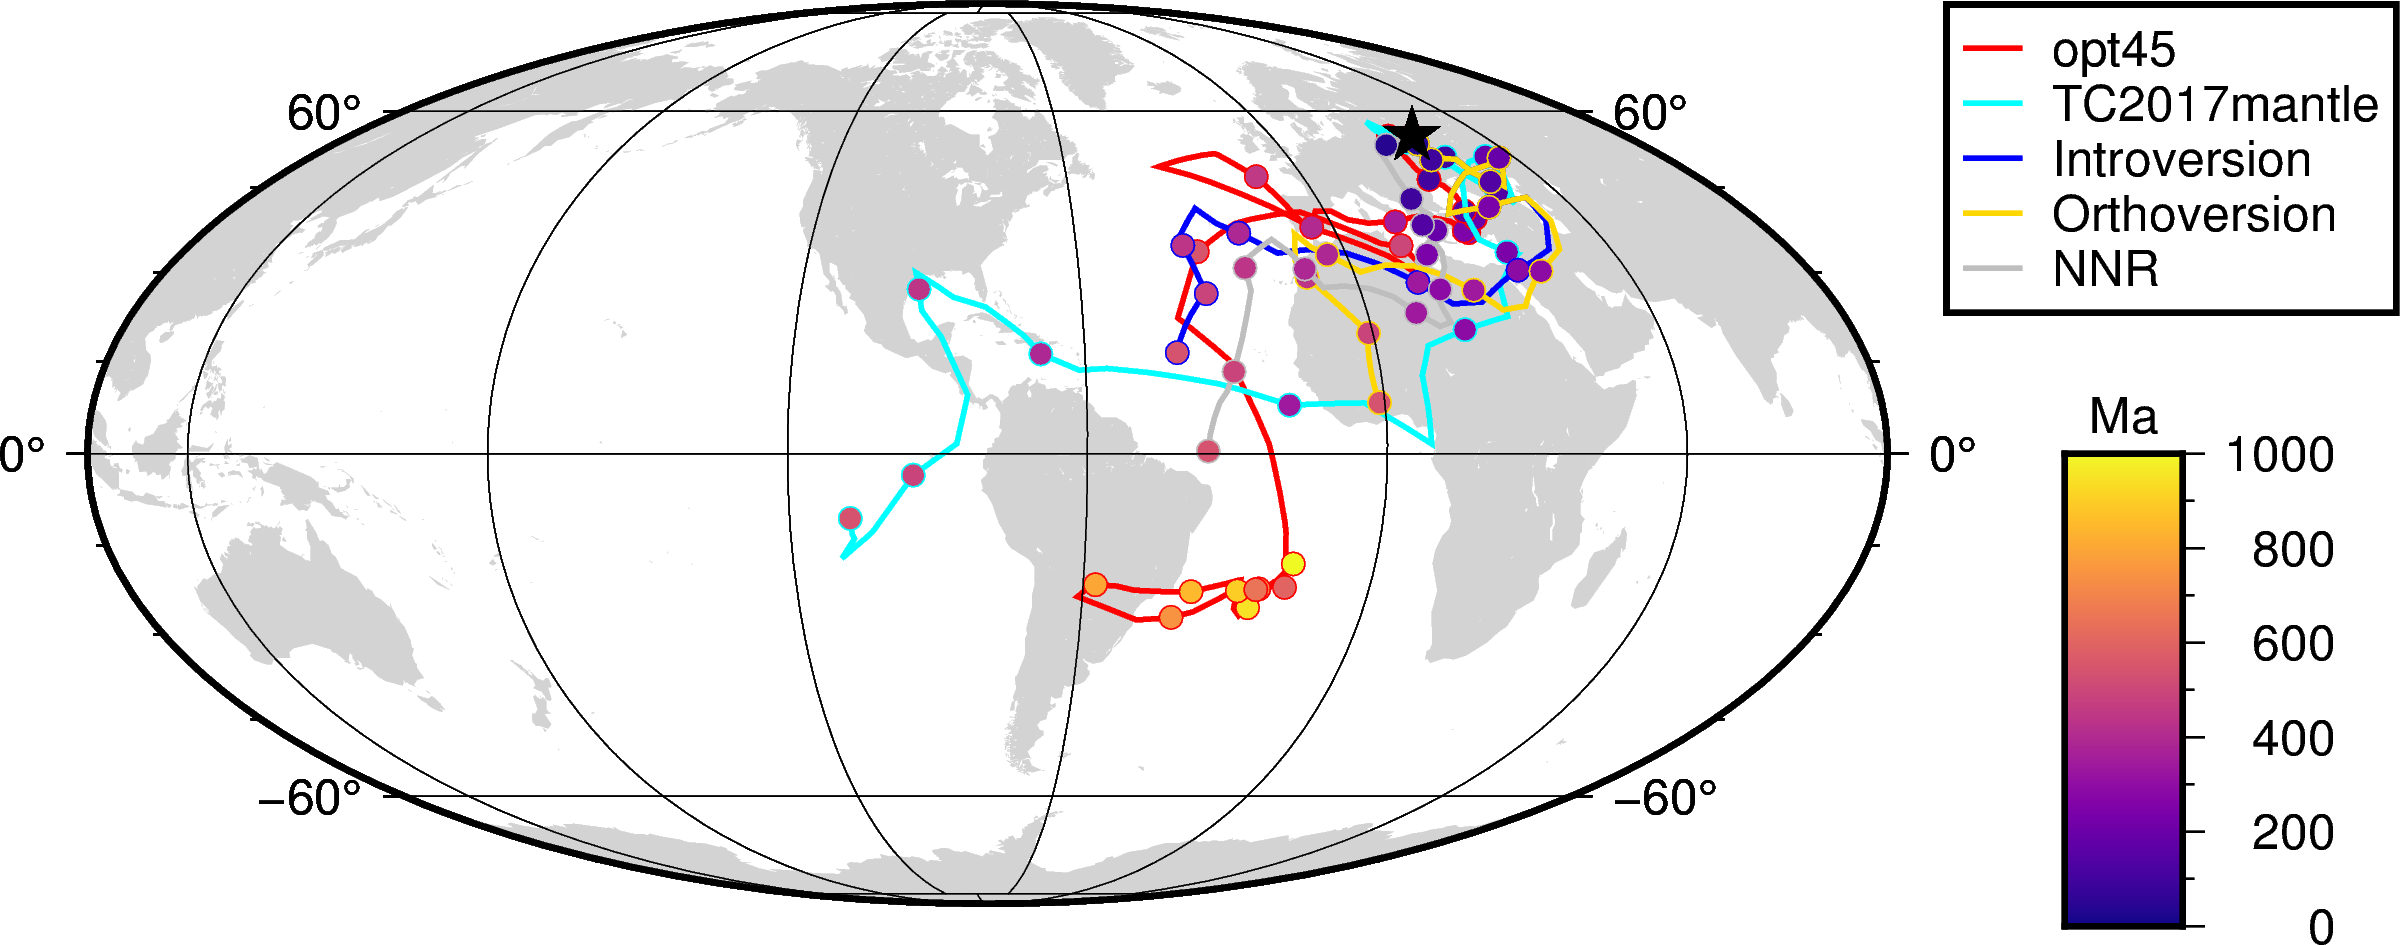

In [9]:
fig = PlotTrailFigure((55,40),302, 'Baltica', region=[100,460,-90,90])
fig.show(width=800)

#fig.savefig(os.path.join(output_dir, 'OptimisationComparison_MotionPath_Baltica.png'))


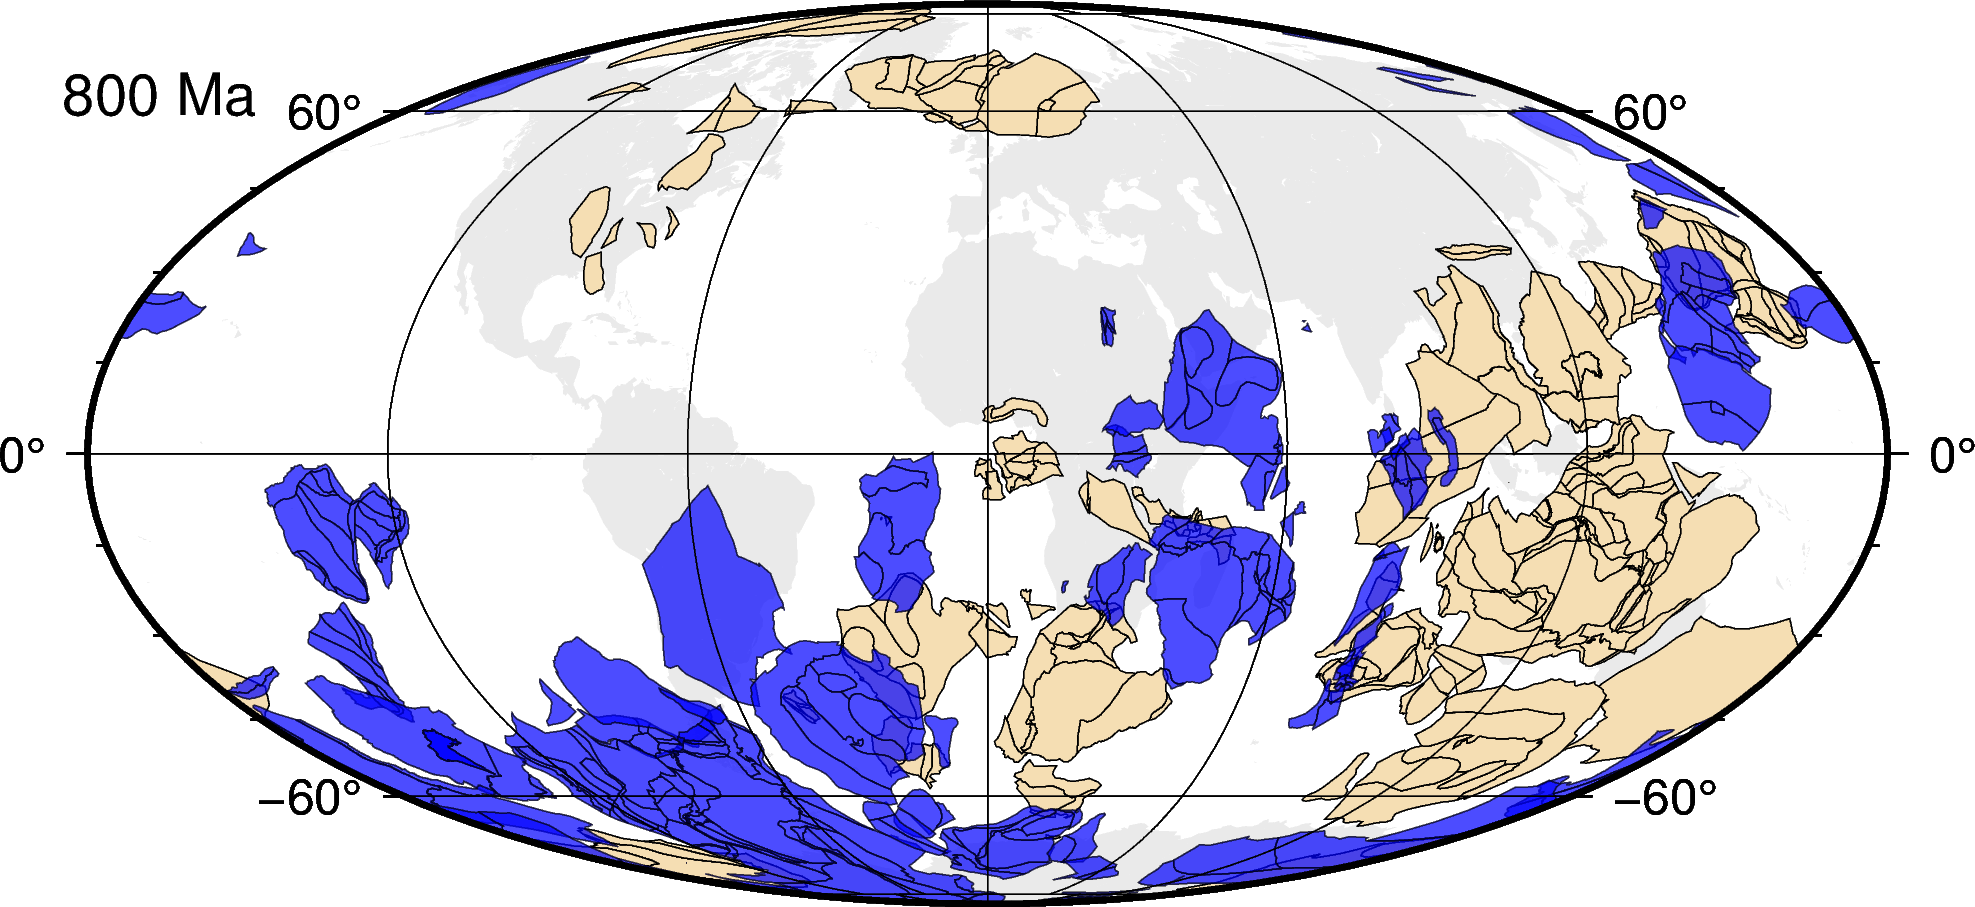

In [10]:
reconstruction_time = 800.

def compare_rodinia(reconstruction_time, transparancy=0.):
    
    reconstructed_continents_M2020 = M2020.polygon_snapshot('continents', reconstruction_time)
    reconstructed_continents_M2020_opt = M2020_opt.polygon_snapshot('continents', reconstruction_time)

    #reconstructed_plates_M2020 = M2020.plate_snapshot(reconstruction_time)

    fig = pygmt.Figure()
    fig.basemap(region='d', projection='W6i', frame='afg')
    fig.coast(land='gray90')
    reconstructed_continents_M2020.plot(fig, color='wheat')
    reconstructed_continents_M2020_opt.plot(fig, color='blue', t=transparancy)

    fig.basemap(region='d', projection='W6i', frame='afg')
    fig.text(x=0.04,y=0.45,text='{:0.0f} Ma'.format(reconstruction_time),
             region='0/1/0/1', projection='x6i', font='14,,', N=True)
    return fig


fig = compare_rodinia(800., transparancy=30.)
fig.show(width=1000)

#fig.savefig(os.path.join(output_dir, 'OptimisationComparison_800Ma.png'))

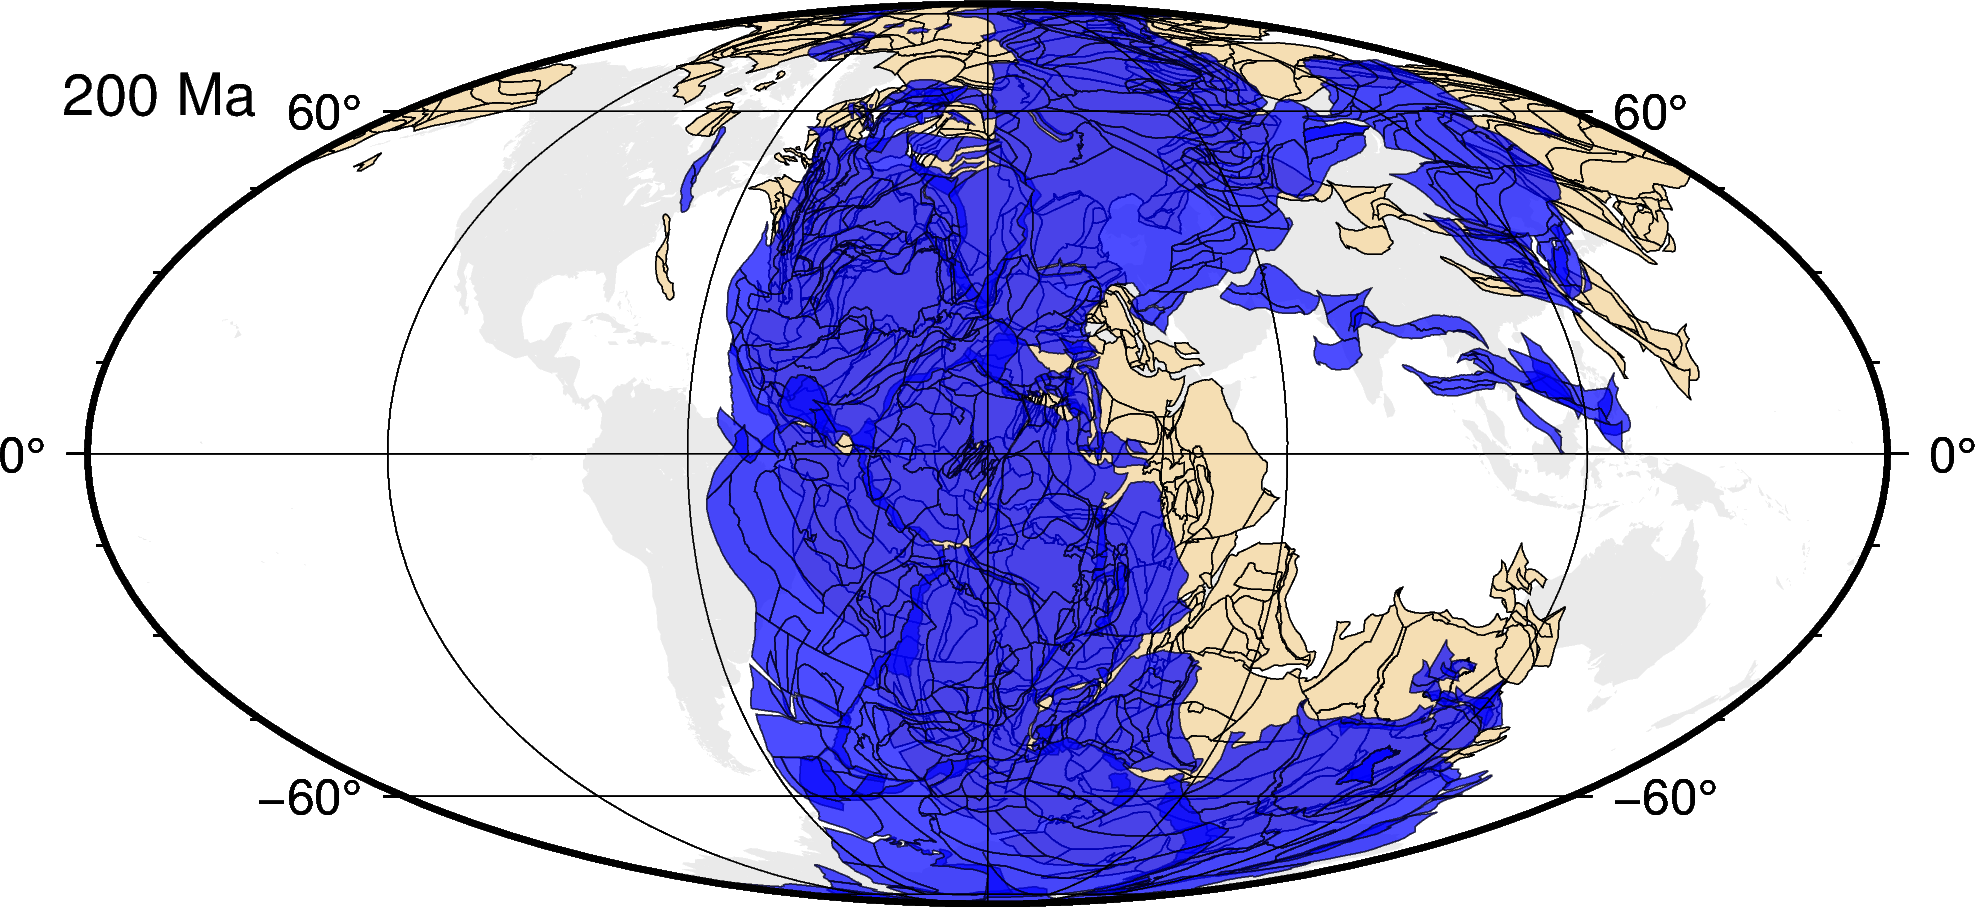

In [11]:
fig = compare_rodinia(200., transparancy=30)
fig.show(width=1000)

#fig.savefig(os.path.join(output_dir, 'OptimisationComparison_200Ma.png'))


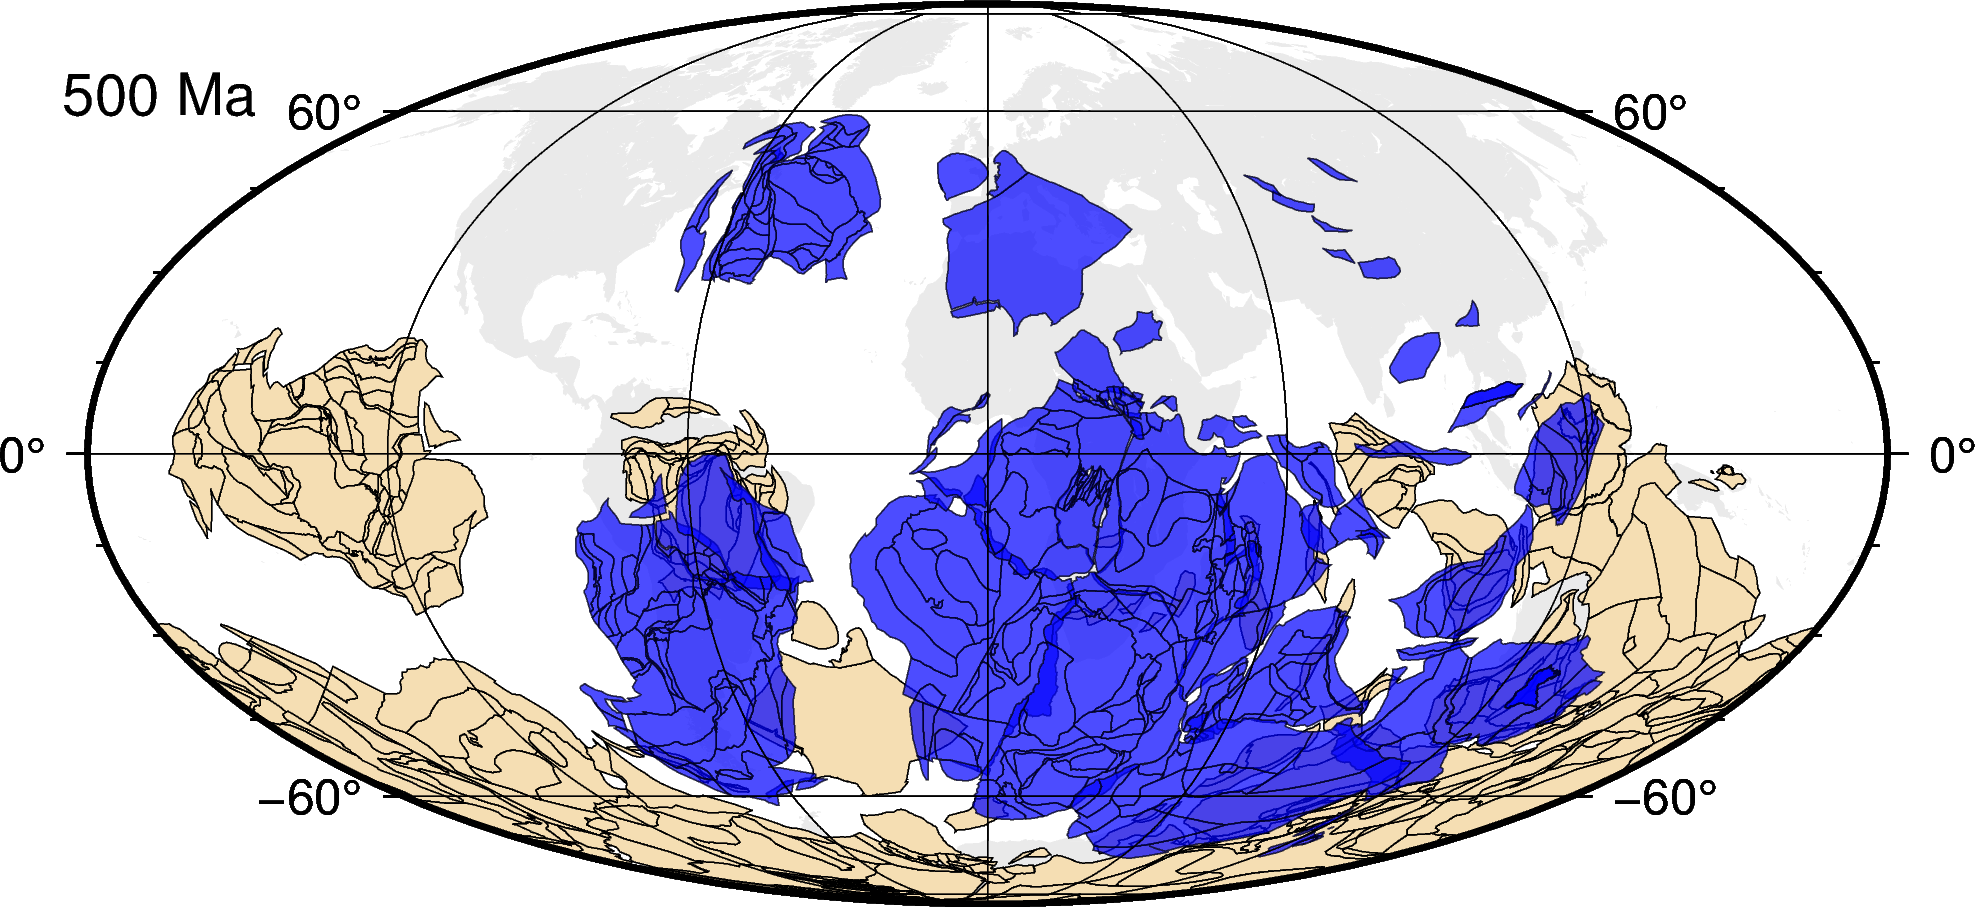

In [12]:
fig = compare_rodinia(500., transparancy=30)
fig.show(width=1000)

#fig.savefig(os.path.join(output_dir, 'OptimisationComparison_500Ma.png'))
